In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### DCGAN (with utkcropped image dataset)
- 이번에는 utkcropped image dataset을 이용해서 DCGAN으로 **RGB색상이 포함되어 있는**사람 얼굴 이미지를 만들어 보고 싶다.
- 저번에 사람 얼굴 데이터를 이용해서 구했을 때에는 흑백의 색상으로 사람 얼굴이 나왔었기 때문에 아쉬움이 너무 컸고, 또한 주변 잡음이 너무 많았다.
- 그래서 이번에는 DCGAN관련 논문을 읽어보고 'Hands on Machine Learning'이라는 책의 DCGAN부분을 좀 더 읽어보면서 네트워크의 원리를 더 잘 이해해 보려고 노력을 했다.

    - 이번 학습과는 별개로 tensorflow-gpu를 설치하려다 뭔가를 잘못 건드렸는지 갑자기 CUDA Toolkit 10.0.0을 설치하라는 OS Error이 떴다. 기존에 colab으로 할 때에는 그냥 GPU를 사용할 수 있었는데, jupyter로 하려면 직접 GPU를 깔아야 한다는 번거로움이 존재했다.
    - 일단 현재 jupyter이 작동하는 환경이 가상 환경임을 고려할 때 Anaconda Prompt로 들어가서 현재 가상환경을 (base)에서 activate tensorflow로 불러서 ```pip install tensorflow-gpu```를 하면 된다. 
        - 그러나 중요한 것은 그 이전에 CUDA Toolkit의 10.0.0버전만을 tensorflow가 지원하기 때문에 최신 버전인 11.0.1이 있었기 때문에 오류가 발생한 것이다.  
        
        
- 앞서 DCGAN을 다른 얼굴 데이터셋(흑백)을 이용해서 실행 할 때에 잠시 정리를 했었지만, DCGAN의 원리를 다시 정리해 보면 이는 **심층 합성곱 GAN**이다.
    1. 판별자에 있는 Pooling Layer을 stride convolution layer으로 바꾸고 생성자에 있는 Pooling Layer은 Conv2DTranspose(전치 합성곱)을 이용한다.
    2. 생성자와 판별자에 Batch Normalization을 사용한다. 단, 생성자의 출력층과 판별자의 입력층은 제외해야 한다.
    3. 층을 깊이 쌓기 위해서 **완전 연결 은닉층을 제거**한다.
    4. 생성자의 출력층은 tanh를 이용하는데, 이 때문에 **출력값의 픽셀의 scale을 -1~1로 정규화**해야 한다.
    5. 생성자의 출력층을 제외한 나머지 모든 층은 ReLU를 이용한다. 단, 성능을 높이기 위해 selu도 괜찮다.
        - relu는 음수의 출력값이 나오면 무조건 0으로 취급해 이후의 layer의 출력에도 영향을 줄 것이기 때문이다.
    6. 판별자의 모든 층은 LeakyReLU를 이용한다.
    
    
- 생성자의 목적은 말 그대로 **판별자를 속일 수 있는 이미지 데이터**를 만드는 것이고 판별자는 이를 판별 한 후에 가중치와 실제 이미지 데이터의 정보를 생성자에 gradient값으로서 가중치를 갱신할 수 있도록 넘겨주는 것이 목적이다.
 
 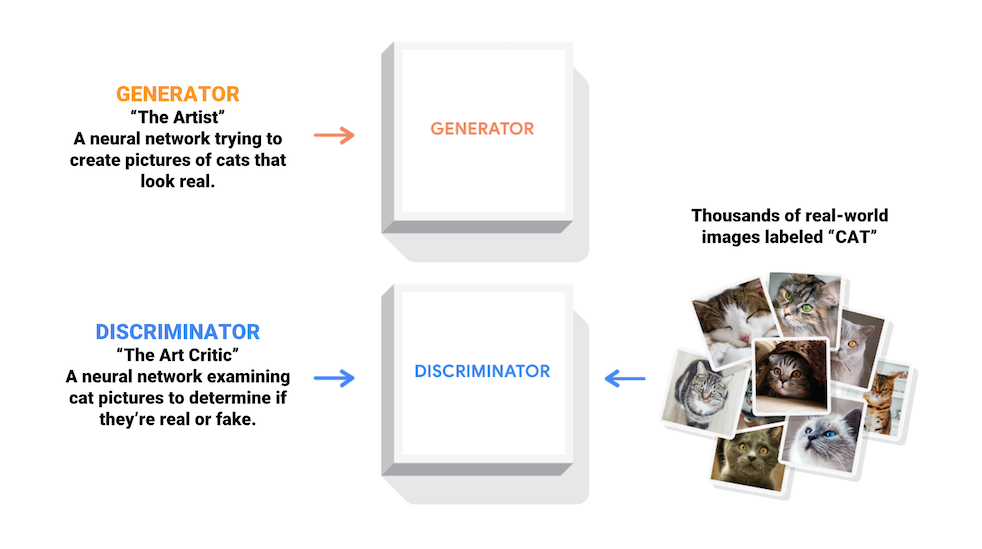

In [3]:
import pathlib
rootpath = pathlib.Path('C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped')
img_path = list(rootpath.glob('*/'))

In [4]:
for i in range(len(img_path)):
    img_path[i] = str(img_path[i])

In [5]:
img_path[:10]

['C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_0_0_20170112213500903.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_0_0_20170112215240346.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_1_0_20170110183726390.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_1_0_20170112213001988.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_1_0_20170112213303693.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_1_0_20170112215032192.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_1_0_20170117195420803.jpg.chip.jpg',
 'C:\\Users\\이지혜\\Downloads\\182088_408792_bundle_archive\\utkcropped\\utkcropped\\100_1_0_20170119212053665.jpg.chip.jpg',
 'C:\\Us

In [6]:
def load_image(image_dir):
    img = tf.io.read_file(image_dir)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128, 128))
    img = (img - 0.5)*2
    return img

**후에 generator의 출력 layer의 activation function이 출력 범위가 -1에서 1 사이인 tanh이기 때문에 범위 또한 조정해줌**

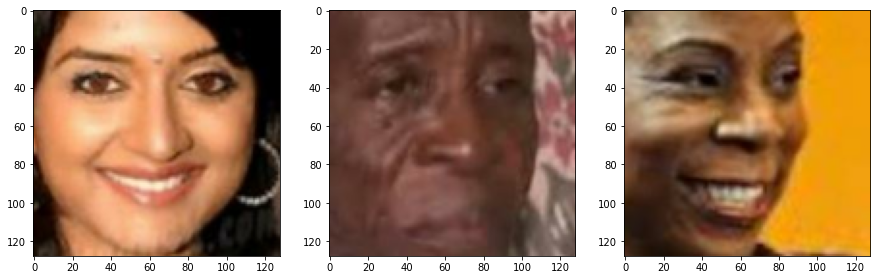

In [7]:
plt.figure(figsize = (15,15))
index = np.random.randint(0, len(img_path), 3)
for i in range(3):
    plt.subplot(1,3,i+1)
    img = load_image(img_path[index[i]])
    plt.imshow((img/2)+0.5)
plt.show()

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 8

In [9]:
len(img_path)

23707

In [10]:
train_index = np.random.randint(0, len(img_path), 1000)
train_path = []
for i in train_index:
    train_path.append(img_path[i])

In [11]:
dataset = tf.data.Dataset.list_files(train_path)
dataset = dataset.map(load_image)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
dataset

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>

#### Model 만들기
1. 생성자와 감별자 원리
    - **생성자**는 랜덤한 잡음으로부터 이미지를 생성하기 위해서 ```Conv2DTranspose```를 이용한다. 처음에 있는 Dense층은 이 잡음을 input으로 받고, 우리가 원하는 이미지의 사이즈인(이 경우에는 (128,128,3)이 나오도록 upsampling(크기 확대)를 여러번 한다.
    - **감별자**는 **합성곱 신경망 기반의 이미지 분류기**이다. 이는 입력받은 이미지의 진위 여부를 판정하고, 마지막 출력층에 tanh를 이용하기 때문에 진짜면 양수, 가짜면 음수를 출력한다.
   
2. 생성자와 감별자의 loss와 optimizer
    - **감별자의 손실 함수**의 경우 가짜 이미지에서 얼마나 진짜 이미지를 잘 판별하는지 수치화한다. 
        - 진짜 이미지에 대한 감별자의 예측과 1로 이루어진 행렬을 비교하고, 생성자에 의해 생성된 이미지에 대한 감별자의 예측과 0으로 이루어진 행렬을 비교한다.
    - **생성자의 손실 함수**는 판별자를 얼마나 잘 속였는지 판별하게 된다.
        - 생성한 가짜 이미지에 대한 판별자의 예측과 1로 이루어진 행렬을 비교한다.


In [13]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.activations import selu, tanh
sgd = tf.keras.optimizers.SGD(lr = 0.0002, momentum = 0.5)

In [14]:
codings_size = 100

In [15]:
generator = Sequential()
generator.add(Dense(8*8*1024, input_shape = [codings_size]))
generator.add(Reshape([8,8,1024]))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(512, activation = 'selu', kernel_size = (5,5), strides = 2, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(256, activation = 'selu', kernel_size = (5,5), strides = 2, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, activation = 'selu', kernel_size = (5,5), strides = 2, padding = 'same'))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, activation = 'tanh', kernel_size = (5,5), strides = 2, padding = 'same'))

In [16]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65536)             6619136   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 1024)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 1024)        4096      
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 512)       13107712  
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 512)       2048      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       3277056   
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 256)       1

In [59]:
discriminator = Sequential()
discriminator.add(Conv2D(128, kernel_size = 5, strides = 2, padding = 'same',activation = tf.keras.layers.LeakyReLU(0.2), input_shape = [128,128,3]))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(256, kernel_size = 5, strides = 2, padding = 'same', activation = tf.keras.layers.LeakyReLU(0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(512, kernel_size = 5, strides = 2, padding = 'same', activation = tf.keras.layers.LeakyReLU(0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(1024, kernel_size = 5, strides = 2, padding = 'same', activation = tf.keras.layers.LeakyReLU(0.2)))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation = 'sigmoid'))


In [60]:
discriminator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 64, 64, 128)       9728      
_________________________________________________________________
dropout_23 (Dropout)         (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 32, 32, 256)       819456    
_________________________________________________________________
dropout_24 (Dropout)         (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 512)       3277312   
_________________________________________________________________
dropout_25 (Dropout)         (None, 16, 16, 512)       0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 8, 8, 1024)      

In [61]:
dcgan = Sequential([generator, discriminator])

In [62]:
dcgan.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128, 128, 3)       23840515  
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 17280257  
Total params: 41,120,772
Trainable params: 41,116,932
Non-trainable params: 3,840
_________________________________________________________________


#### Train 함수 만들기
- 판별자, 생성자 모두 따로 학습을 시켜야 하기 때문에 이를 위해 사용자 지정 함수를 만들어 주어야 한다.

In [68]:
noise = tf.random.normal(shape = [BATCH_SIZE, 100])
fake_img = generator(noise)

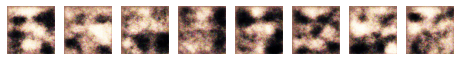

In [73]:
plot_multiple_images(fake_img)

In [74]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((np.asarray(image)/2)+0.5)
        plt.axis("off")
    plt.show()

In [75]:
def train_dcgan(gan, dataset, batch_size, coding_size, epochs):
    generator, discriminator = gan.layers
    for epoch in range(epochs):
        print(epoch+1)
        for x in dataset:
            noise = tf.random.normal(shape = [batch_size, coding_size])
            fake_img = generator(noise)
            x_fake_real = tf.concat([fake_img, x], axis = 0)
            y = tf.constant([[0.]]*batch_size+[[1.]]*batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_real,y)
            
            noise = tf.random.normal(shape = [batch_size, coding_size])
            y = tf.constant([[1.]]*batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y)
        plot_multiple_images(fake_img, 4)

In [76]:
discriminator.compile(loss = 'binary_crossentropy', optimizer = 'sgd')
discriminator.trainable = False
dcgan.compile(loss = 'binary_crossentropy', optimizer = 'sgd')

1


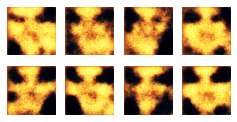

2


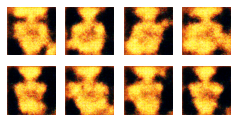

3


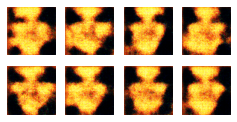

4


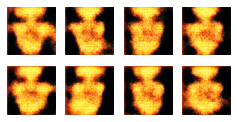

5


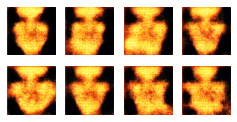

6


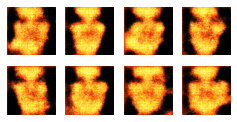

7


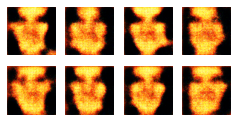

8


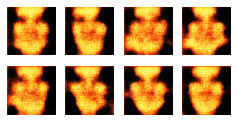

9


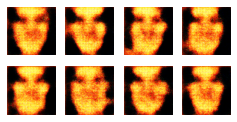

10


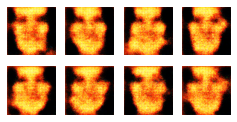

11


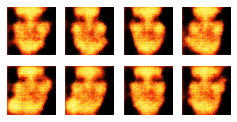

12


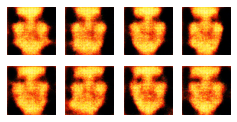

13


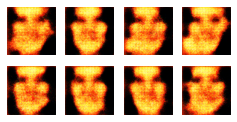

14


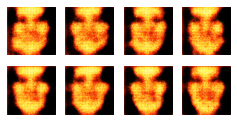

15


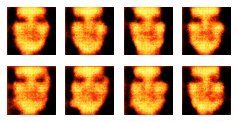

16


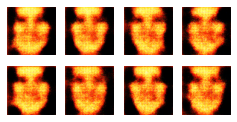

17


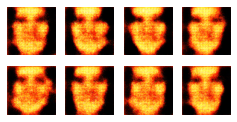

18


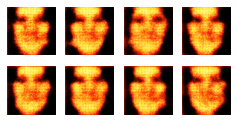

19


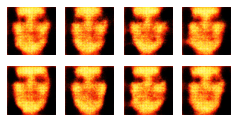

20


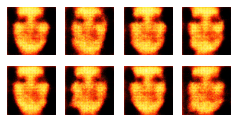

21


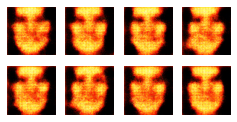

22


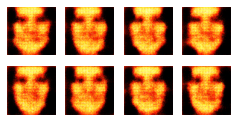

23


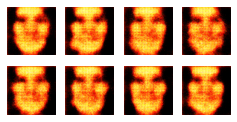

24


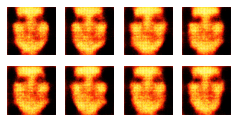

25


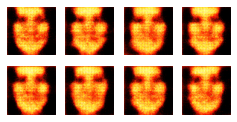

26


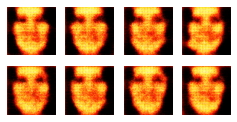

27


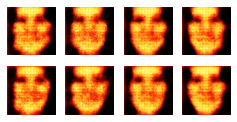

28


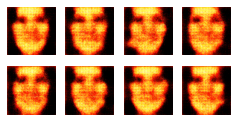

29


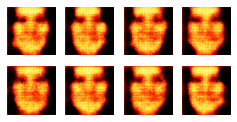

30


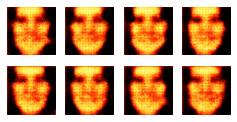

31


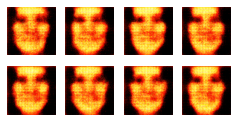

32


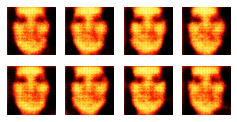

33


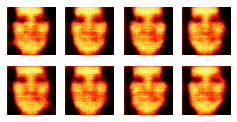

34


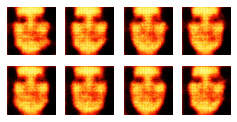

35


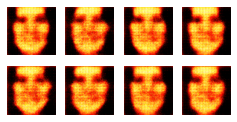

36


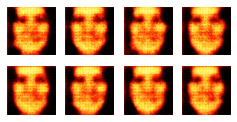

37


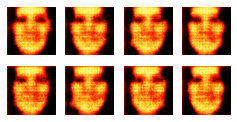

38


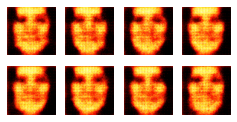

39


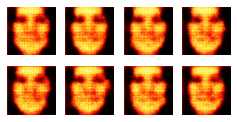

40


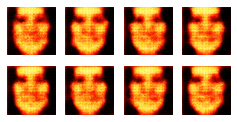

41


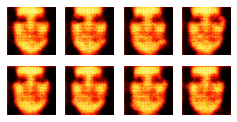

42


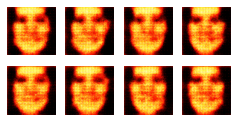

43


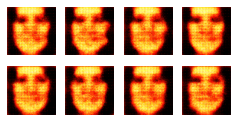

44


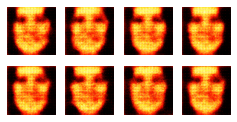

45


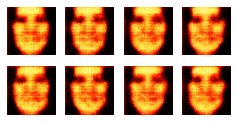

46


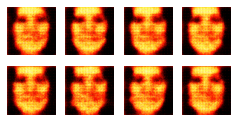

47


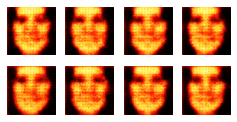

48


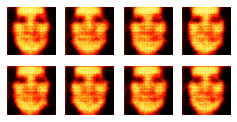

49


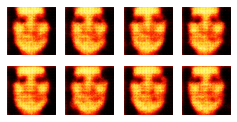

50


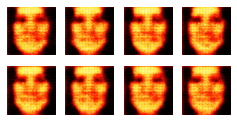

In [77]:
train_dcgan(dcgan, dataset, BATCH_SIZE, 100, 50)

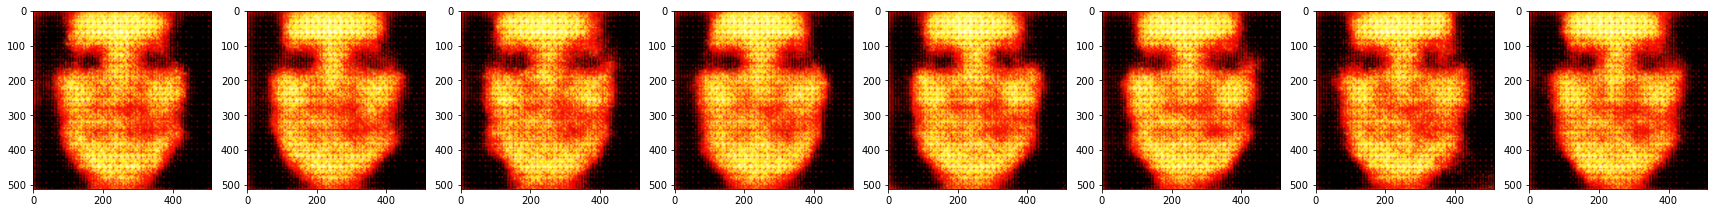

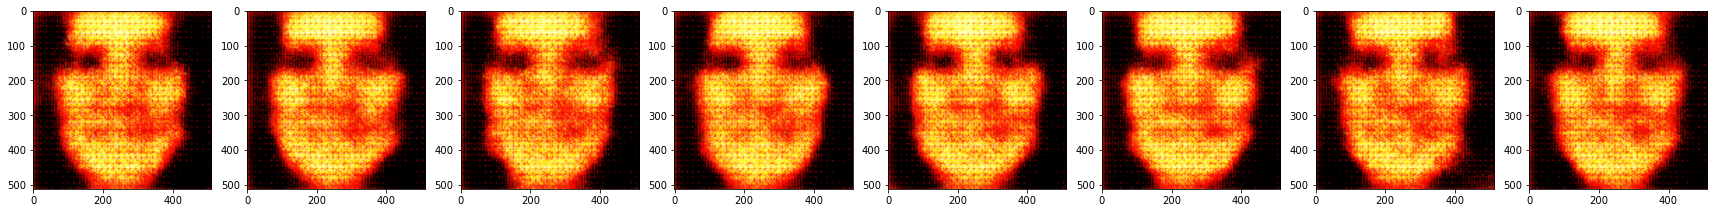

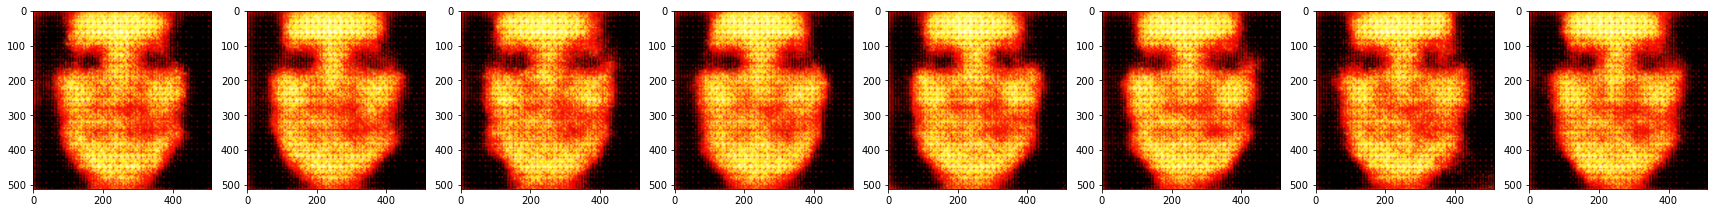

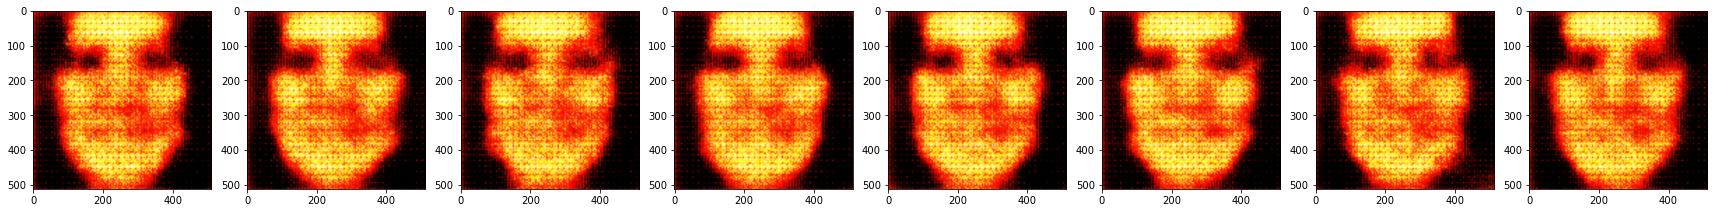

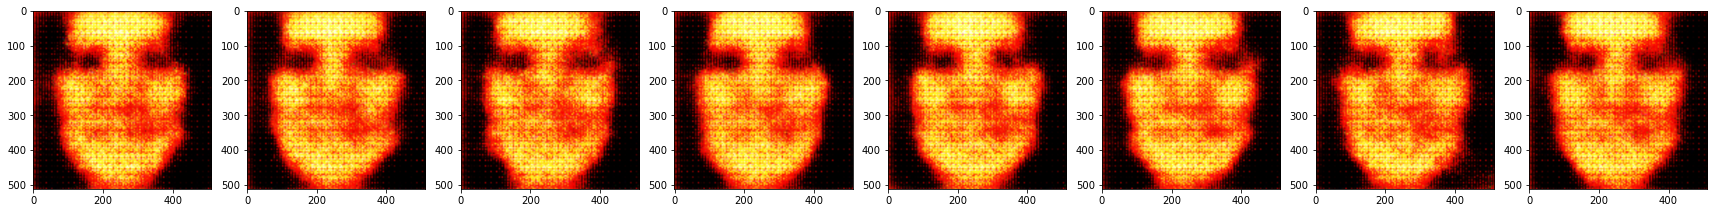

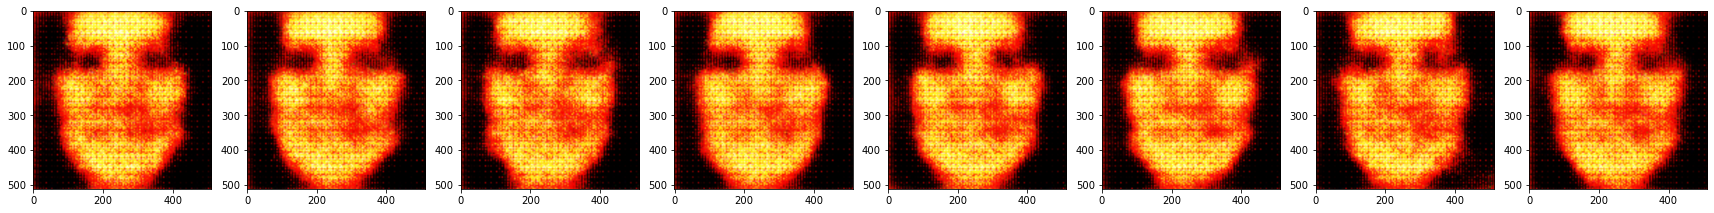

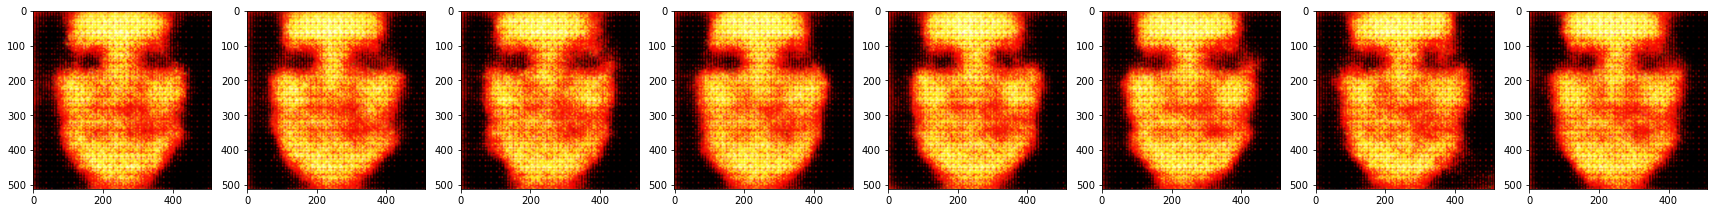

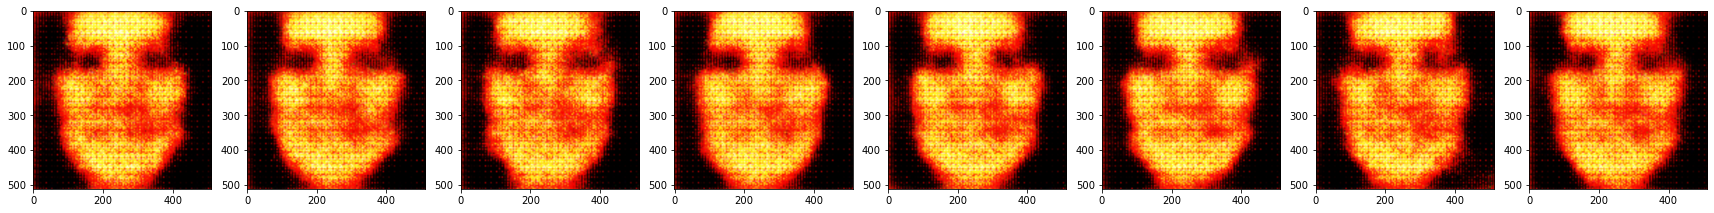

In [80]:
for _ in range(8):
    test_noise = tf.random.normal(shape = [BATCH_SIZE, 100])
    final_pred = generator(noise)
    plt.figure(figsize = (30,30))
    for index, image in enumerate(final_pred):
        plt.subplot(1,8,index+1)
        img = (image/2)+0.5
        img = tf.image.resize(img, (512, 512))
        plt.imshow(img)
plt.show()

**이렇게 GAN으로 이미지가 형성이 되었는데, 사람의 이목구비의 형태가 보이기는 하지만 당연하게도 확실하게 진짜 사람 얼굴로 보이려면 훨씬 많은 횟수로 학습을 시켜야 할 것 같다.**

**내가 설계한 DCGAN 모델의 구조 및 선택한 activation function에 대한 설명과 이유를 정리해 놓았다.**
- 솔직히 처음에는 channel을 줄여나가고 'noise'라는 것을 넣어 이미지를 만든다는 것이 이해가 전혀 가지 않았지만, 책을 읽다 보니 **잠재 표현**이라는 것으로 이해를 한다면 결국 생성자는 **점진적으로 판별자가 진짜라고 믿을 만한 이미지를 만들기 위한 학습을 진행**하는 것이다. 다만 주의할 점은 이렇게 생성자를 학습하는 과정에서 **판별자의 가중치는 동결**되어야 한다는 것이다.  

- 판별자는 말그대로 진위여부만 판별하면 되기 때문에 마지막 출력층은 Flatten Layer로 차원을 줄인 다음에 Dense Layer로 첫 입력층에 주어지는 입력값인 (이미지, 진위여부label)을 받아 본인의 예측값과 비교한 손실을 구한다.
    - 정확한 데이터(진위여부가 올바르게 labeling된)로는 판별자 본인이 학습을, 속이려는 데이터로는 생성자가 학습을 한다.

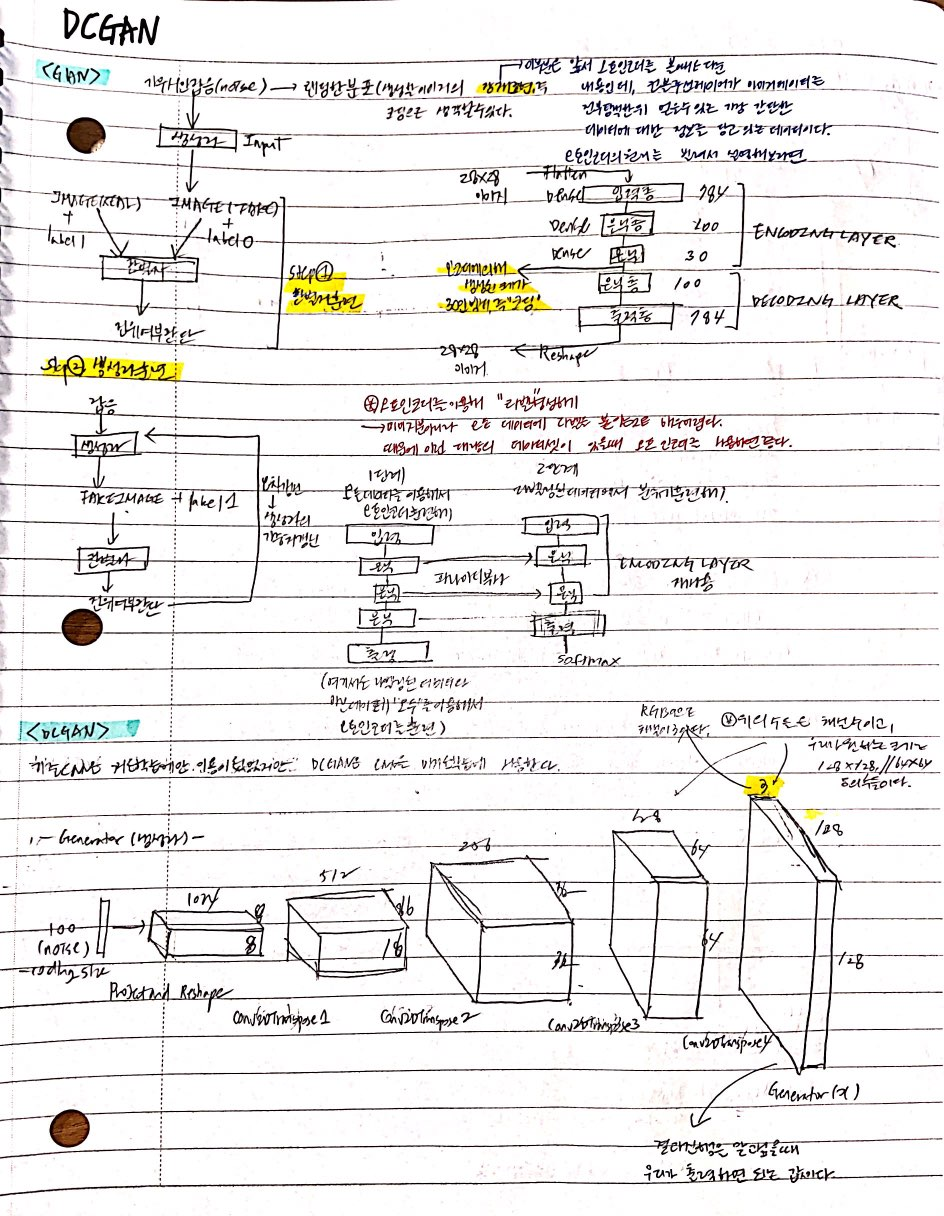


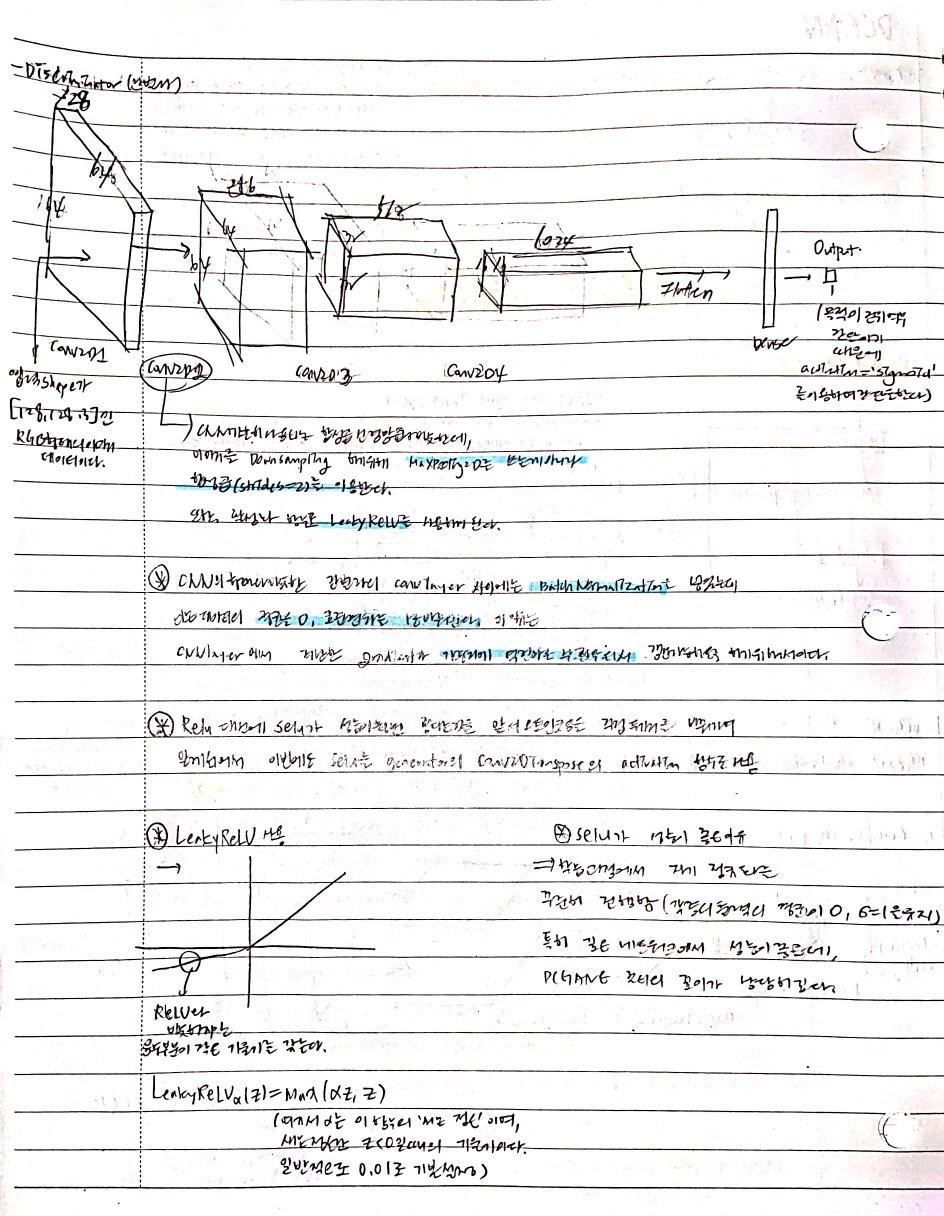